## Problem Statement:
#### This project aims to analyze the historical stock prices of a selected company using yfinance. We will perform exploratory data analysis, time series visualization, trend analysis, and forecasting using statistical and machine learning models.

## 1. Collect Data using yfinance
### 1.1 Install and import required libraries:
### 1.2 Download stock data (e.g., Reliance Industries Limited - RELIANCE.NS on NSE):

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

stock_data = yf.download('AAPL', start='2024-01-01')
stock_data.head(10)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,


## 2. Data Preprocessing
### 2.1 Check for Mising Values

In [56]:
print(stock_data.isnull().sum())

Price   Ticker
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


#### No Missing values are there in our data.

In [57]:
stock_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.532089,187.315382,182.792533,186.033072,82488700
2024-01-03,183.150391,184.770668,182.335277,183.120571,58414500
2024-01-04,180.824356,181.997307,179.800504,181.062914,71983600
2024-01-05,180.098709,181.669281,179.094742,180.903888,62303300
2024-01-08,184.452560,184.492330,180.416793,181.003268,59144500


In [58]:
stock_data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-04-02,223.889999,225.190002,221.020004,221.320007,35905900
2025-04-03,203.190002,207.490005,201.250000,205.539993,103419000
2025-04-04,188.380005,199.880005,187.339996,193.889999,125910900
2025-04-07,181.460007,194.149994,174.619995,177.199997,160466300
2025-04-08,172.419998,190.339996,169.210007,186.699997,120363400


In [59]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 318 entries, 2024-01-02 to 2025-04-08
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   318 non-null    float64
 1   (High, AAPL)    318 non-null    float64
 2   (Low, AAPL)     318 non-null    float64
 3   (Open, AAPL)    318 non-null    float64
 4   (Volume, AAPL)  318 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 14.9 KB


## 3. Exploratory Data Analysis (EDA)
### 3.1 Basic Statistics

In [60]:
stock_data.describe()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,318.000000,318.000000,318.000000,318.000000,3.180000e+02
mean,211.116985,213.140409,208.923807,210.940314,5.709544e+07
std,25.465165,25.564987,25.044793,25.306173,2.962212e+07
min,164.224564,165.617978,163.308889,164.572913,2.323470e+07
25%,186.258121,188.038515,184.723420,186.199803,4.154760e+07
50%,220.577431,222.570141,217.430744,220.237533,4.970535e+07
75%,229.517353,231.886450,227.244866,229.472462,6.263040e+07
max,258.735504,259.814335,257.347047,257.906429,3.186799e+08


### 3.2 Visualizing Stock Prices Over Time
##### Time Series Analysis with LineChart

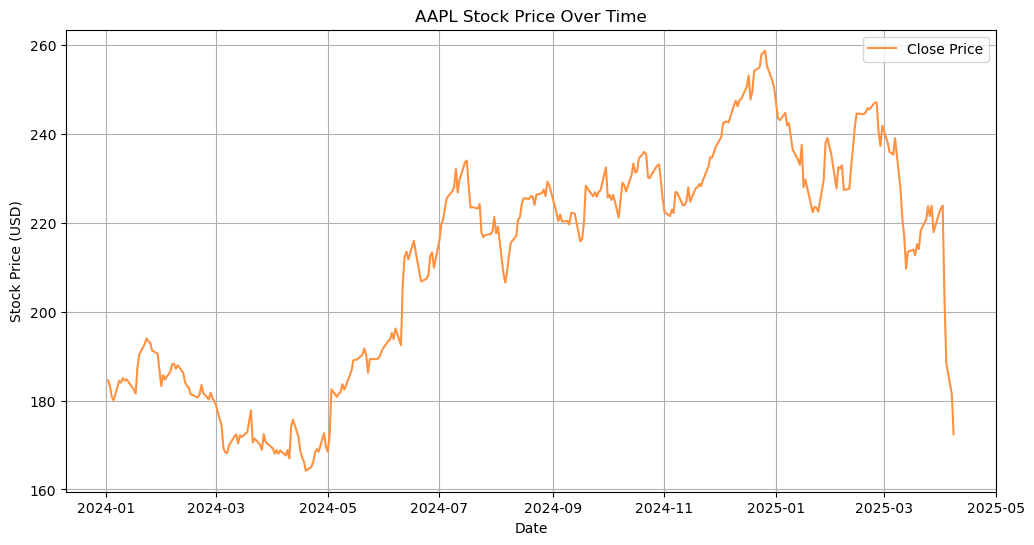

In [61]:
#Plot the Closing Price
plt.figure(figsize=(12,6))
plt.plot(stock_data['Close'], label='Close Price', color='#FF9140')
plt.title('AAPL Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

### 3.3 Calculate & Plot Moving Averages (Trend Analysis)

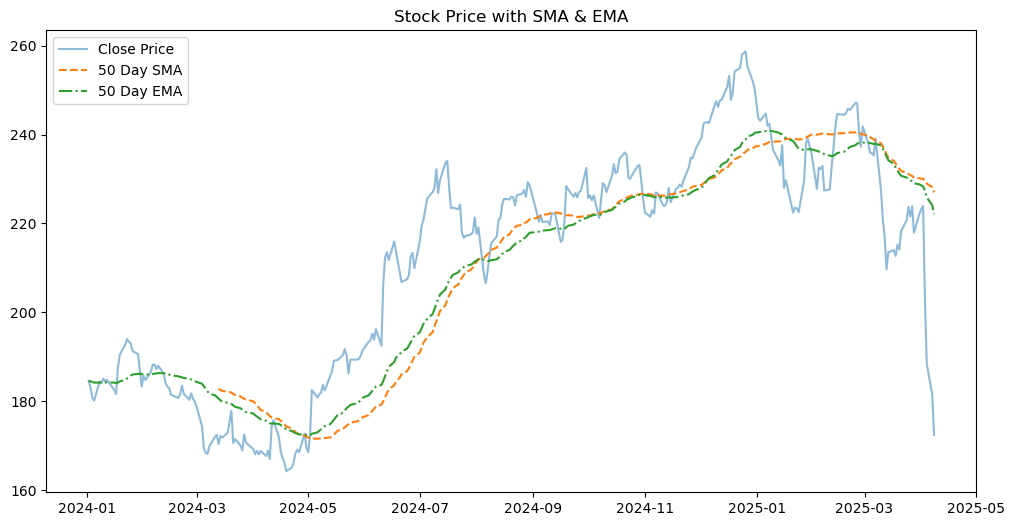

In [62]:
stock_data['SMA'] = stock_data['Close'].rolling(window=50).mean()
stock_data['EMA'] = stock_data['Close'].ewm(span=50, adjust=False).mean()

plt.figure(figsize=(12,6))
plt.plot(stock_data['Close'], label='Close Price', alpha=0.5)
plt.plot(stock_data['SMA'], label='50 Day SMA', linestyle='--')
plt.plot(stock_data['EMA'], label='50 Day EMA', linestyle='-.')
plt.legend()
plt.title("Stock Price with SMA & EMA")
plt.show()


## Moving Averages Show Market Trends
1. Simple Moving Average (SMA) helps smoothen price fluctuations to reveal overall trends.
2. Exponential Moving Average (EMA) reacts faster to recent price changes, helping to spot trend reversals early.
3. Close Price > SMA & EMA : Therefore the stock is in an uptrend (bullish trend)

### 3.4 Analyzing Daily Returns (Stock Volatility)

In [63]:
stock_data['Daily Return'] = stock_data['Close'].pct_change()

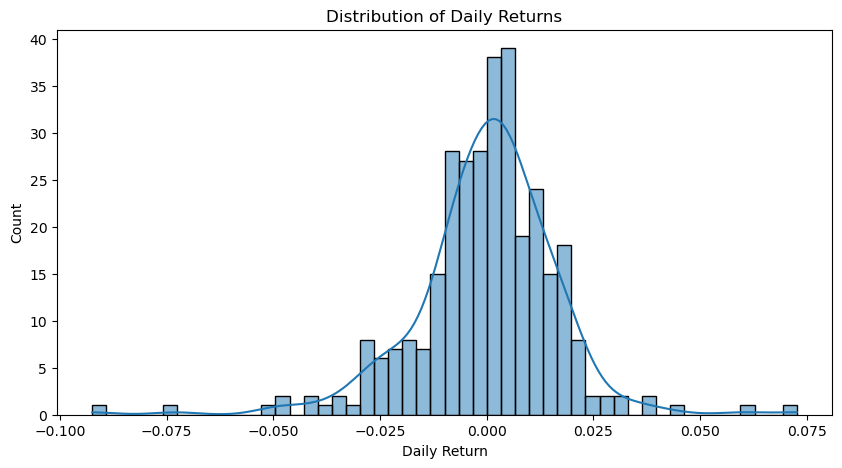

In [64]:
plt.figure(figsize=(10,5))
sns.histplot(stock_data['Daily Return'].dropna(), bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Count')
plt.show()

1. Negative Values (-X) → Stock price dropped that day.
2. Zero (0) → Stock price did not change.
3. Positive Values (+X) → Stock price increased that day.
4. Reliance’s daily return distribution is centered around 0 with occasional large spikes, it indicates high volatility and risk.


## 4. Time Series Decomposition
#### (Trend, Seasonality, Residuals)

### 4.1 Classical Time Series Decomposition

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(stock_data['Close'], model='additive', period=30)

In [66]:
trend_additive = decomposition.trend
seasonal_additive = decomposition.seasonal
residual_additive = decomposition.resid

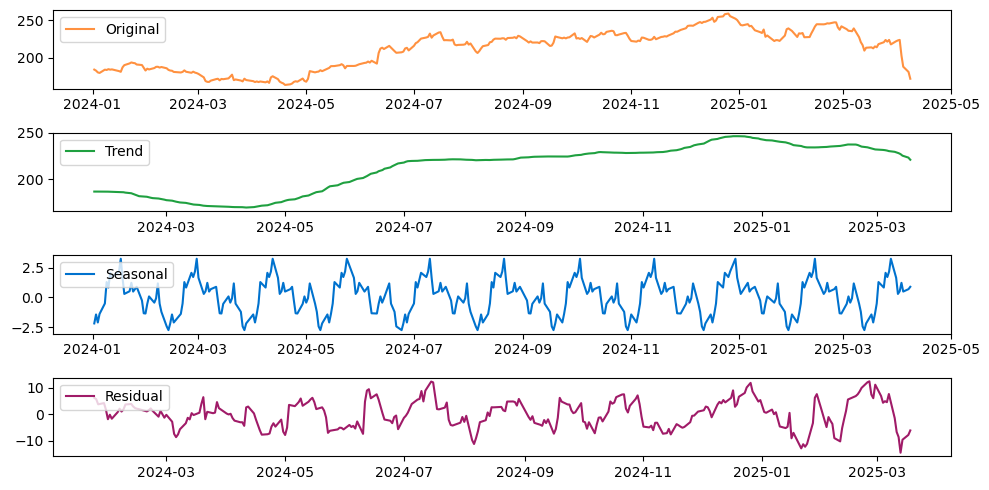

In [67]:
plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(stock_data['Close'], label='Original', color='#FF9140')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_additive, label='Trend', color='#1fa040')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal_additive, label='Seasonal', color='#0072ce')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual_additive, label='Residual', color='#a01b68')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

1. Trend - upward trend
2. Seasonality - seasonal variations are constant, so Additive Decomposition
3. Residuals/Noise - 

### 4.2 STL Decomposition

In [68]:
from statsmodels.tsa.seasonal import STL

stl_decomposition = STL(stock_data['Close'], period=30)
result = stl_decomposition.fit()

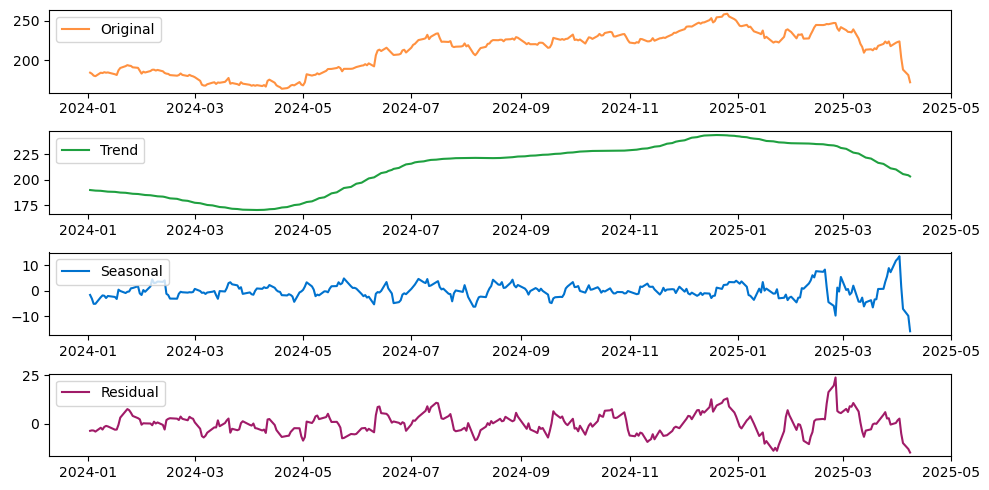

In [69]:
plt.figure(figsize=(10,5))
plt.subplot(411)
plt.plot(result.observed, label='Original', color='#FF9140')
plt.legend()
plt.subplot(412)
plt.plot(result.trend, label='Trend', color='#1fa040')
plt.legend()
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='#0072ce')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residual', color='#a01b68')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Checking for Stationarity 

### 4.1 Augmented Dickey-Fuller (ADF) Test:
#### Performing the ADF Test on Closing Prices

#### Hypothesis of ADF Test:
1. Null Hypothesis (H0): The time series is non-stationary.
2. Alternative Hypothesis(H1): The time series is stationary.

In [70]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)

    print("ADF Test Statistic: ", round(result[0],3))
    print("p-value: ", round(result[1],3))
    print("Critical Values: ", result[4])

    if result[1]<0.05:
        print("The time series is stationary (Reject H0).")
    else:
        print("The time series is non-stationary (Accept the H0).")

adf_test(stock_data['Close'])

ADF Test Statistic:  -1.235
p-value:  0.658
Critical Values:  {'1%': -3.4512146067362317, '5%': -2.870730188960711, '10%': -2.5716664849383113}
The time series is non-stationary (Accept the H0).


### 4.2 KPSS Test
#### Hypothesis of KPSS Test:
1. Null Hypothesis (H0): The time series is stationary.
2. Alternative Hypothesis(H1): The time series is non-stationary.

In [71]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    result = kpss(series, regression='ct')       # 'c' for constant(level stationarity), 'ct' for trend
    
    print('KPSS test results:')
    print('KPSS Test Statistic: ', round(result[0],2))
    print('p-value: ', result[1])
    print('Critical Values: ', result[3])

    if result[1]<0.05:
        print("The time series is non-stationary (Reject H0).")
    else:
        print("The time series is stationary (Accept the H0).")

kpss_test(stock_data['Close'])

KPSS test results:
KPSS Test Statistic:  0.34
p-value:  0.01
Critical Values:  {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
The time series is non-stationary (Reject H0).


#### In ADF Test p-value > 0.05: The time series is non-stationary.
#### In KPSS Test p-value < 0.05: The time series is non-stationary.
#### so we need to apply transformations.

### 4.3 Making the time series Stationary

In [72]:
prices=stock_data['Close']

In [73]:
adf_test(prices)

ADF Test Statistic:  -1.235
p-value:  0.658
Critical Values:  {'1%': -3.4512146067362317, '5%': -2.870730188960711, '10%': -2.5716664849383113}
The time series is non-stationary (Accept the H0).


#### 4.3.1 Apply Differencing
##### the series is non-stationary, we can subtract the previous value from the current value:

In [74]:
prices_diff = prices.diff()

#### 4.3.2 Re-run ADF test on differenced data

In [75]:
adf_test(prices_diff.dropna())

ADF Test Statistic:  -14.821
p-value:  0.0
Critical Values:  {'1%': -3.4512146067362317, '5%': -2.870730188960711, '10%': -2.5716664849383113}
The time series is stationary (Reject H0).


## 5. Model Selection & Foracasting
### Time Series Forcasting Models

### 5.1 ARIMA (AutoRegrssive Integrated Moving Average)

#### 5.1.1 Using Auto-ARIMA to select ARIMA parameters
##### Instead of manually selecting ARIMA parameters (p, d, q), we use auto_arima, which finds the best values.

In [76]:
from pmdarima.arima import auto_arima

# Using auto_arima to find the best ARIMA parameters
stepwise_fit = auto_arima(stock_data['Close'],  
                          seasonal=False,  
                          trace=True )

# Best ARIMA order
print("Optimal ARIMA Order:", stepwise_fit.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1699.142, Time=1.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1700.830, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1694.124, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1695.379, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1698.868, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1694.758, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1695.157, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1695.092, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1692.161, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1692.799, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1693.199, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1693.415, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1693.131, Time=0.25 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.926 seconds
Optimal ARIMA Order: (

#### 5.1.2 Fitting the ARIMA Model & Forecasting Future Stock Prices

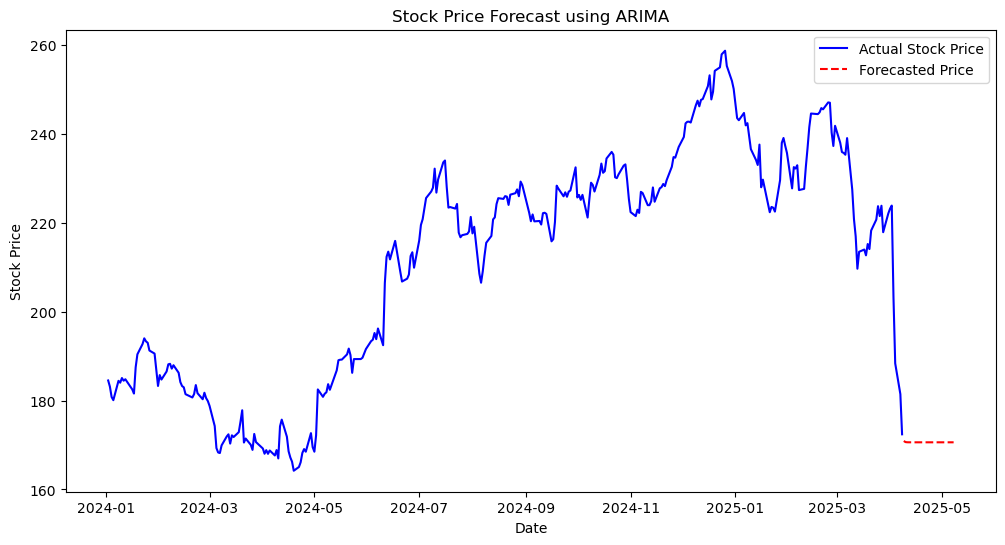

In [77]:
from statsmodels.tsa.arima.model import ARIMA

# Define the model with chosen (p, d, q) values
model = ARIMA(stock_data['Close'], order=stepwise_fit.order)

# Fit the model
arima_result = model.fit()

# Forecasting for the next 30 days
forecast_steps = 30
forecast = arima_result.forecast(steps=forecast_steps)

# Creating a date range for the forecast
future_dates = pd.date_range(start=stock_data.index[-1], periods=forecast_steps+1, freq='D')[1:]

# Convert forecast results into a DataFrame
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': forecast.values})

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(stock_data['Close'], label='Actual Stock Price', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecasted Price', color='red', linestyle='dashed')
plt.title("Stock Price Forecast using ARIMA")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

### 5.2 Testing a Seasonal Model: SARIMA

In [78]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model with seasonality
sarima_model = SARIMAX(stock_data['Close'], 
                       order=stepwise_fit.order, 
                       seasonal_order=(1, 1, 1, 30))  # 30-day seasonality

# Fit the model
sarima_result = sarima_model.fit()

# Forecast for 30 days
sarima_forecast = sarima_result.forecast(steps=30)


### 5.3 Trying an Alternative Model: Prophet

11:42:44 - cmdstanpy - INFO - Chain [1] start processing
11:42:46 - cmdstanpy - INFO - Chain [1] done processing


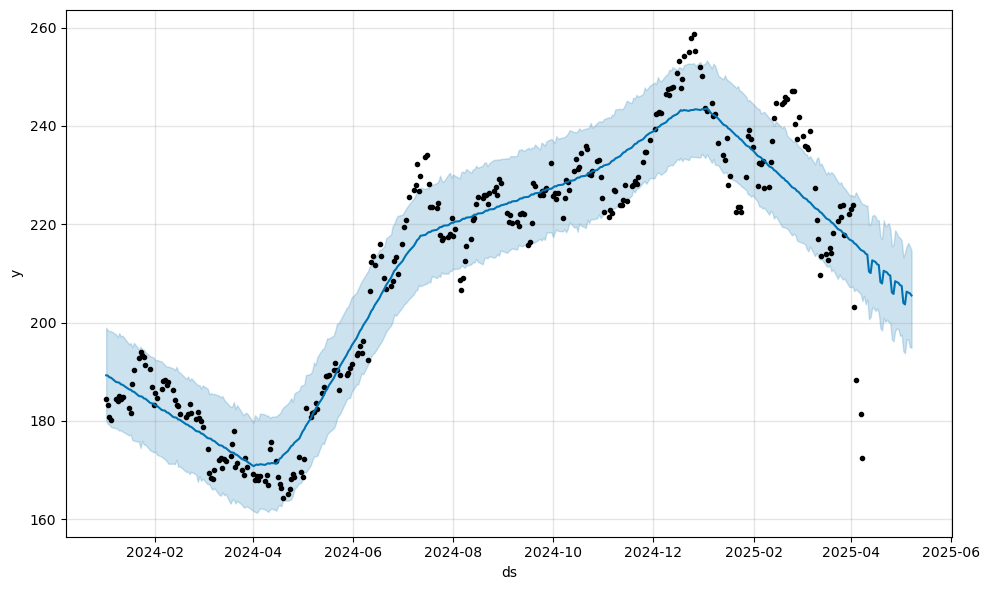

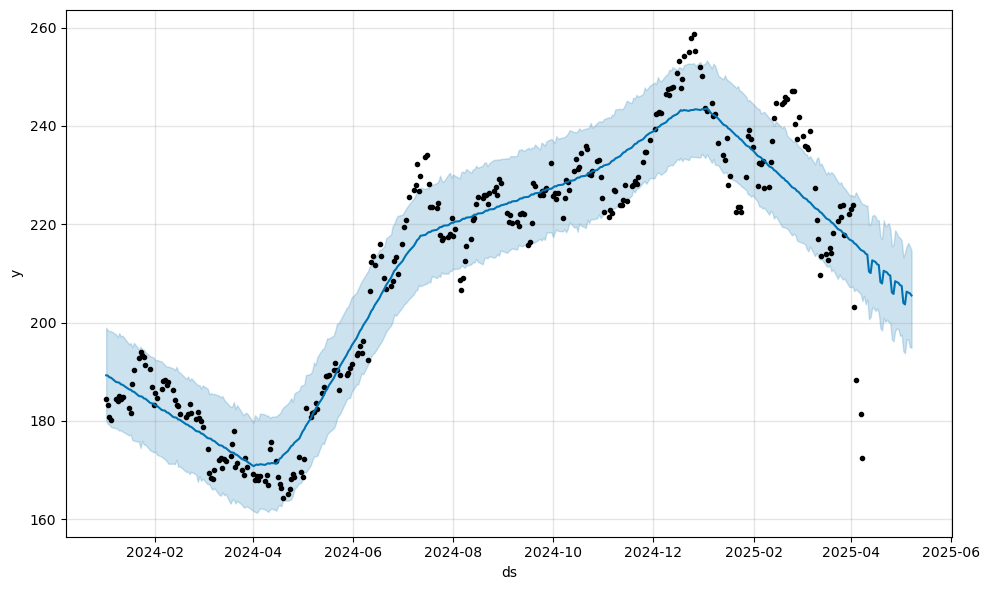

In [79]:
# Prepare data for Prophet
df_prophet = stock_data.reset_index()[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (value)

# Define the model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Create future dates for forecasting
future = prophet_model.make_future_dataframe(periods=30)

# Forecast
forecast = prophet_model.predict(future)

# Plot results
prophet_model.plot(forecast)


### 6. Comparing Model Performance
##### MAE (Mean Absolute Error): Measures how far predictions are from actual values.

##### RMSE (Root Mean Squared Error): Penalizes large errors.

In [80]:
def evaluate_model(actual, predicted, model_name):
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    mae = mean_absolute_error(actual, predicted)
   # mse = mean_squared_error(actual, predicted)
    rmse = mean_squared_error(actual, predicted) ** 0.5

    print(f"\n {model_name} Model Performance:")
    print(f" MAE: {mae:.2f}")
   # print(f" MSE: {mse:.2f}")
    print(f" RMSE: {rmse:.2f}")

evaluate_model(stock_data['Close'][-30:], arima_result.forecast(steps=30), "ARIMA")
evaluate_model(stock_data['Close'][-30:], sarima_forecast, "SARIMA")
evaluate_model(stock_data['Close'][-30:], forecast['yhat'][-30:], "Prophet")



 ARIMA Model Performance:
 MAE: 49.00
 RMSE: 51.66

 SARIMA Model Performance:
 MAE: 50.13
 RMSE: 52.55

 Prophet Model Performance:
 MAE: 15.73
 RMSE: 18.11


#### The model with the lowest RMSE & MAPE is the most accurate.
### So the best model is Prophet.

In [81]:
# Use the last 30 days for testing
train = stock_data['Close'][:-30]
test = stock_data['Close'][-30:]


In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [83]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Automatically select best (p,d,q) using training data
auto_arima_model = auto_arima(train, seasonal=False, trace=True)
p, d, q = auto_arima_model.order

# Train ARIMA on training data
arima_model = ARIMA(train, order=(p, d, q))
arima_fit = arima_model.fit()

# Forecast for next 30 days
arima_forecast = arima_fit.forecast(steps=30)

# Evaluate
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = mean_squared_error(test, arima_forecast, squared=False)
arima_mape = mean_absolute_percentage_error(test, arima_forecast)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1454.067, Time=2.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1456.731, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1457.818, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1457.842, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1456.200, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1458.859, Time=1.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1459.683, Time=0.80 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1459.814, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1458.138, Time=0.64 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1459.274, Time=0.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1453.527, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1458.0

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()

sarima_forecast = sarima_fit.forecast(steps=30)

sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = mean_squared_error(test, sarima_forecast, squared=False)
sarima_mape = mean_absolute_percentage_error(test, sarima_forecast)


In [85]:
from prophet import Prophet
import pandas as pd

# Prepare Prophet-compatible data
df_prophet = stock_data.reset_index()[['Date', 'Close']]
df_prophet.columns = ['ds', 'y']

# Split for Prophet
train_prophet = df_prophet[:-30]
test_prophet = df_prophet[-30:]

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

# Create future dates
future_dates = prophet_model.make_future_dataframe(periods=30)

# Forecast
forecast_prophet = prophet_model.predict(future_dates)

# Extract forecasted y values
prophet_forecast = forecast_prophet[['ds', 'yhat']].set_index('ds').iloc[-30:]
actual_prophet = test_prophet.set_index('ds')['y']

prophet_mae = mean_absolute_error(actual_prophet, prophet_forecast['yhat'])
prophet_rmse = mean_squared_error(actual_prophet, prophet_forecast['yhat'], squared=False)
prophet_mape = mean_absolute_percentage_error(actual_prophet, prophet_forecast['yhat'])


11:45:01 - cmdstanpy - INFO - Chain [1] start processing
11:45:02 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
print("📊 Model Evaluation (30-Day Forecast):")
print(f"ARIMA  - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}%")
print(f"SARIMA - MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}, MAPE: {sarima_mape:.2f}%")
print(f"Prophet- MAE: {prophet_mae:.2f}, RMSE: {prophet_rmse:.2f}, MAPE: {prophet_mape:.2f}%")


📊 Model Evaluation (30-Day Forecast):
ARIMA  - MAE: 27.59, RMSE: 32.10, MAPE: nan%
SARIMA - MAE: 31.89, RMSE: 36.72, MAPE: nan%
Prophet- MAE: 21.33, RMSE: 27.26, MAPE: 7.57%


## 7. Plotting Model Forecasts vs Actual

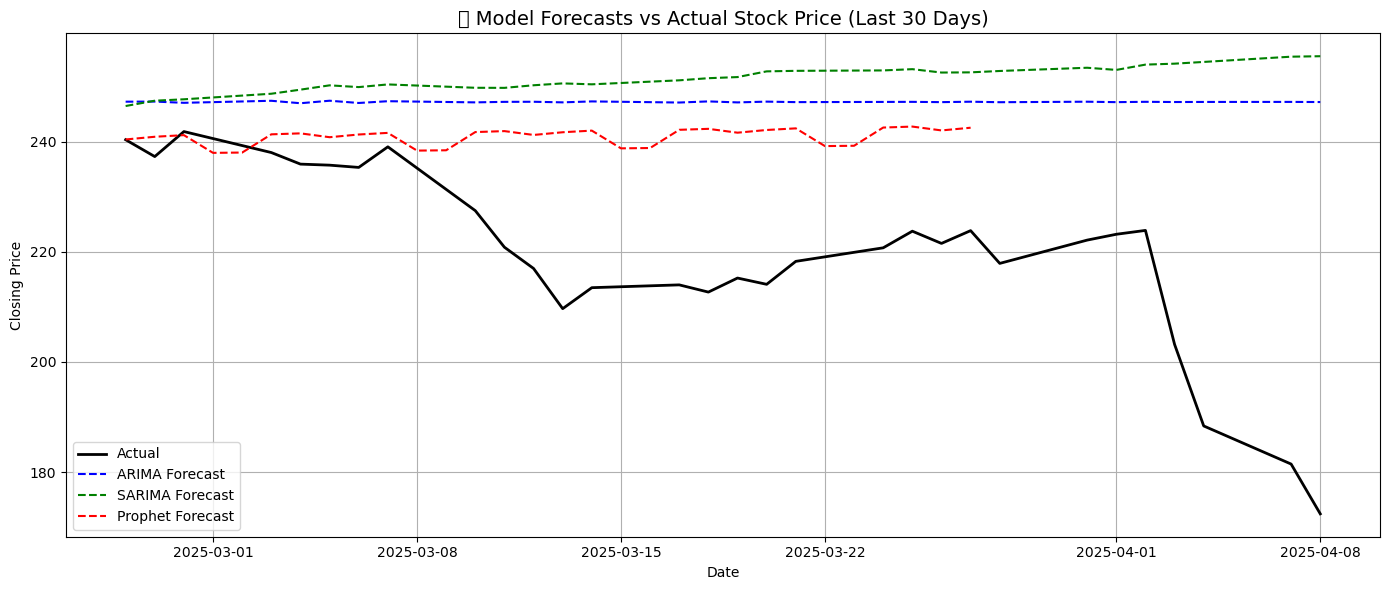

In [87]:
# Align indexes for ARIMA & SARIMA with actual test dates
test_dates = test.index

# Prophet already uses dates
prophet_dates = prophet_forecast.index

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(test_dates, test.values, label='Actual', color='black', linewidth=2)
plt.plot(test_dates, arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')
plt.plot(test_dates, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='green')
plt.plot(prophet_dates, prophet_forecast['yhat'].values, label='Prophet Forecast', linestyle='--', color='red')

plt.title('📉 Model Forecasts vs Actual Stock Price (Last 30 Days)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


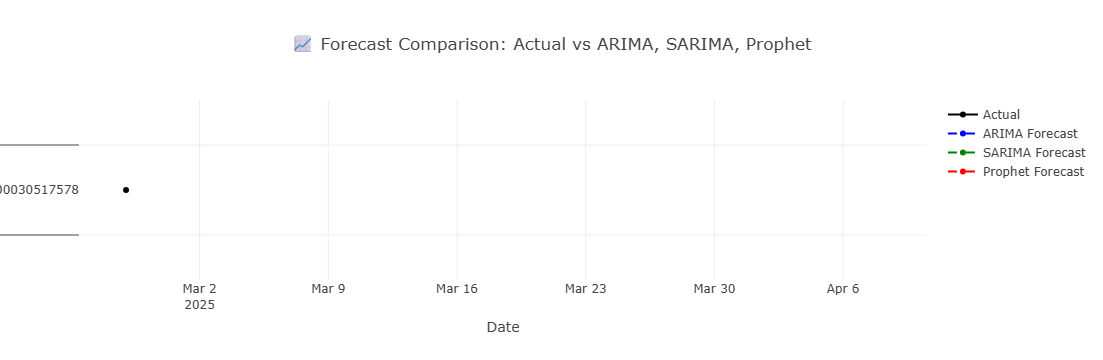

In [90]:
import plotly.graph_objs as go

# Create traces
trace_actual = go.Scatter(x=test.index, y=test.values, mode='lines+markers', name='Actual', line=dict(color='black'))

trace_arima = go.Scatter(x=test.index, y=arima_forecast, mode='lines+markers', name='ARIMA Forecast', line=dict(color='blue', dash='dash'))
trace_sarima = go.Scatter(x=test.index, y=sarima_forecast, mode='lines+markers', name='SARIMA Forecast', line=dict(color='green', dash='dash'))
trace_prophet = go.Scatter(x=prophet_forecast.index, y=prophet_forecast['yhat'], mode='lines+markers', name='Prophet Forecast', line=dict(color='red', dash='dash'))

# Layout
layout = go.Layout(
    title='📈 Forecast Comparison: Actual vs ARIMA, SARIMA, Prophet',
    xaxis_title='Date',
    yaxis_title='Stock Closing Price',
    hovermode='x unified'
)

# Combine and plot
fig = go.Figure(data=[trace_actual, trace_arima, trace_sarima, trace_prophet], layout=layout)
fig.show()


In [54]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.
